In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset_path = "Multi-class Weather Dataset"
image_size = (180, 180)
batch_size = 32
seed = 1337

# Load data
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE

Found 1083 files belonging to 4 classes.
Using 867 files for training.
Using 216 files for validation.


In [3]:
# data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2)
])

RandomFlip("horizontal")
- Randomly flips images left-to-right. Useful when orientation isn't fixed (e.g., weather scenes).
RandomRotation(0.15)
- Randomly rotates images by up to 15% of 360°. Helps model be invariant to slight camera tilts or horizon shifts.
RandomZoom(0.2)
- Randomly zooms images in or out by up to 20%. Useful to simulate varying camera distances.

2025-08-04 15:24:54.713048: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


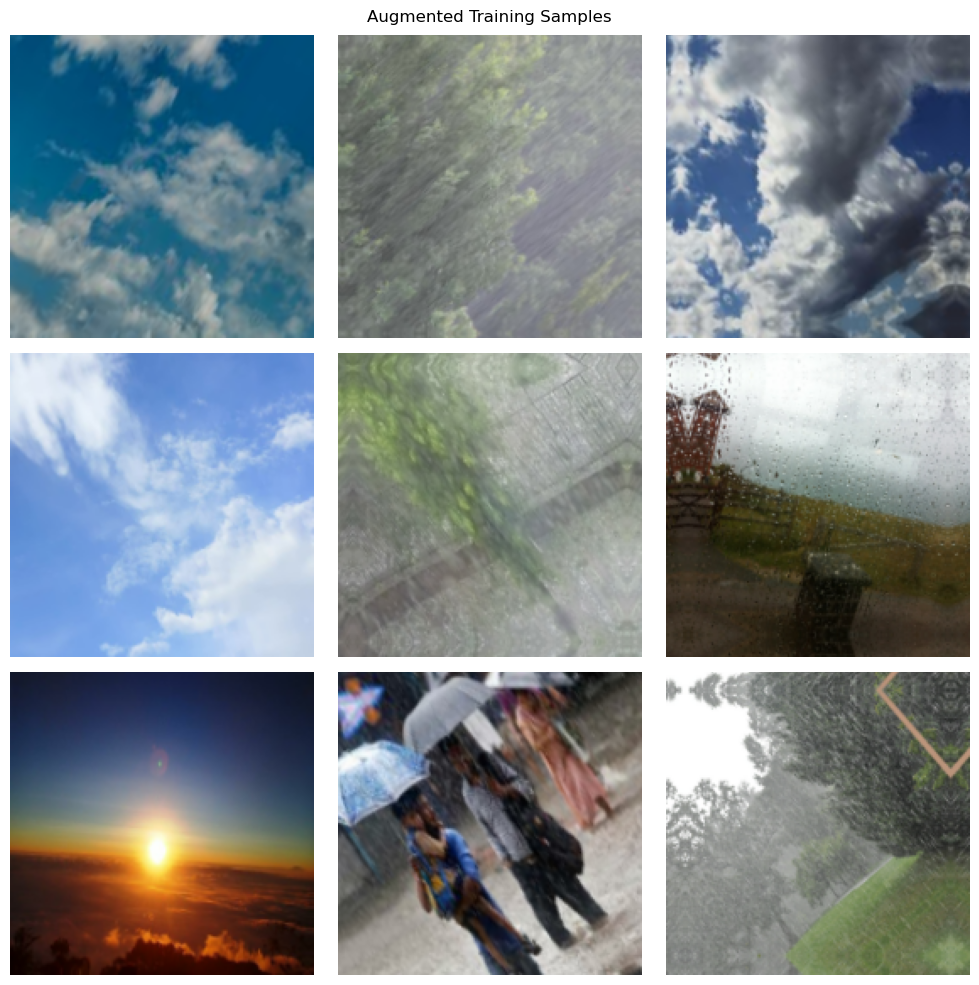

In [4]:
# visualize augmented samples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)[i].numpy().astype("uint8")
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.axis("off")
plt.suptitle("Augmented Training Samples")
plt.tight_layout()
plt.show()

In [5]:
# apply data augmentation to training dataset only
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)
augmented_train_ds = augmented_train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [6]:
def build_baseline_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_baseline_model(image_size + (3,), len(class_names))
model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
history_aug = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.5709 - loss: 1.8195 - val_accuracy: 0.6250 - val_loss: 1.0048
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.7820 - loss: 0.5678 - val_accuracy: 0.8056 - val_loss: 0.7908
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.8143 - loss: 0.4538 - val_accuracy: 0.7593 - val_loss: 0.6376
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.8281 - loss: 0.4057 - val_accuracy: 0.8009 - val_loss: 0.6921
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.8627 - loss: 0.3800 - val_accuracy: 0.8889 - val_loss: 0.4977
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.8339 - loss: 0.4356 - val_accuracy: 0.8565 - val_loss: 0.4984
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8478 - loss: 0.3876 - val_accuracy: 0.8102 - val_loss: 0.8193
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.8743 - loss: 0.3452 - val_accuracy: 0.

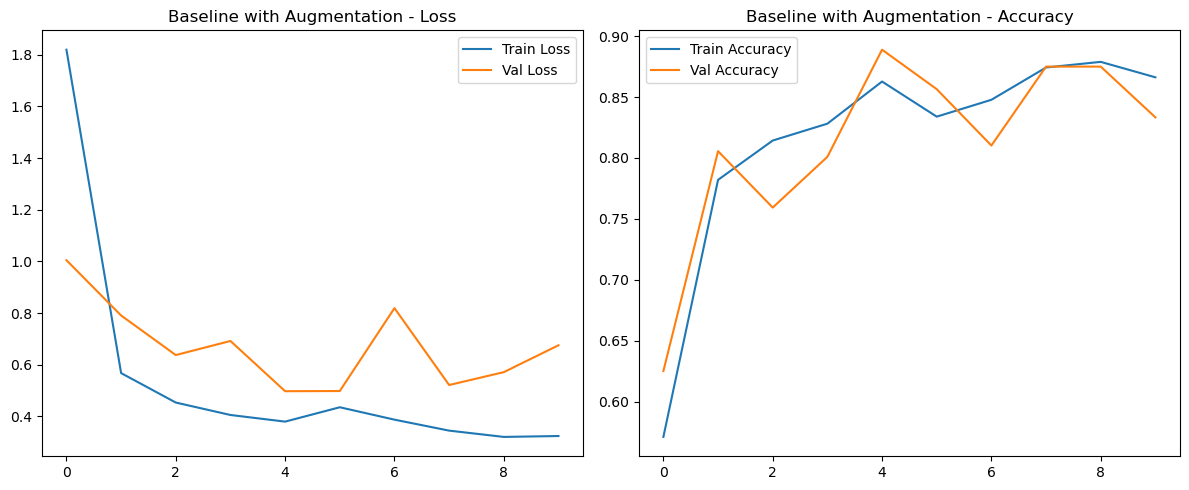

In [8]:
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title(f"{title} - Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.legend()
    plt.title(f"{title} - Accuracy")

    plt.tight_layout()
    plt.show()

plot_learning_curves(history_aug, "Baseline with Augmentation")

In [10]:
#save the model
model.save("BaselineModelWithAugmentation.keras")